## Introduction
In this kernel, we will use various predictive models to see how accurate they are in detecting whether a transaction is a normal payment or a fraud. Features in the dataset are not shown due to privacy except for time and amount. We will use what we have to build a detection model.

## Goals
1. Exploring and understanding the dataset
2. Create a balanced data into sub-dataframe of 50/50 ratio of fraud and no fraud.
3. Determine the Classifiers we are going to use to build the model.
4. Choosing the best model

In [1]:
#Importing LIbraries
import numpy as np #linear algebra
import pandas as pd #data processing
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import time
import warnings
warnings.filterwarnings("ignore")

#Classifier Libraries
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from collections import Counter

#Other ML libraries
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import KFold, StratifiedKFold

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## 1. Exploring and Understanding the Data

In [2]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The mean and 50% have big difference, indicating that the data is hevily skewed.

In [4]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
# The classes are heavily skewed and we need to solve this later
# Let's find the percentage of frauds and no frauds in the dataset
print("No Frauds", round(df['Class'].value_counts()[0]/len(df)*100,2),"% of no frauds")
print("Frauds", round(df['Class'].value_counts()[1]/len(df)*100,2),"% of frauds")

No Frauds 99.83 % of no frauds
Frauds 0.17 % of frauds


**The data is very imbalanced and this is quite typical for fraud detection datasets. If we use this dataframe to train our model, we will get a lot of errors and our algorithm will overfit since it will assume that most transactions are not fraud because our dataset have 99% no frauds.**

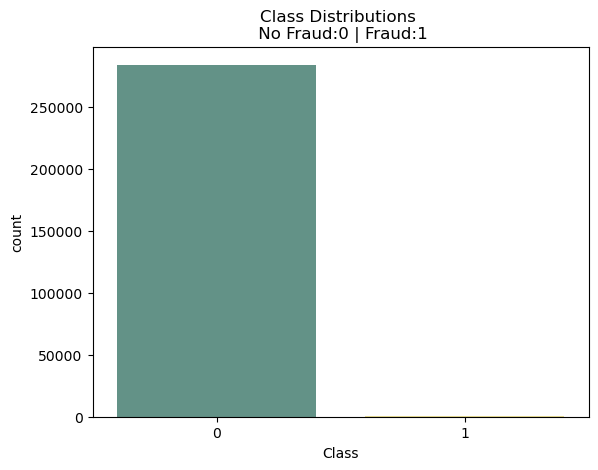

In [7]:
colors = ["#5B9A8B", "#F7E987"]

sns.countplot(data=df,x='Class', palette=colors)

plt.title('Class Distributions \n No Fraud:0 | Fraud:1', fontsize=12)

plt.show()

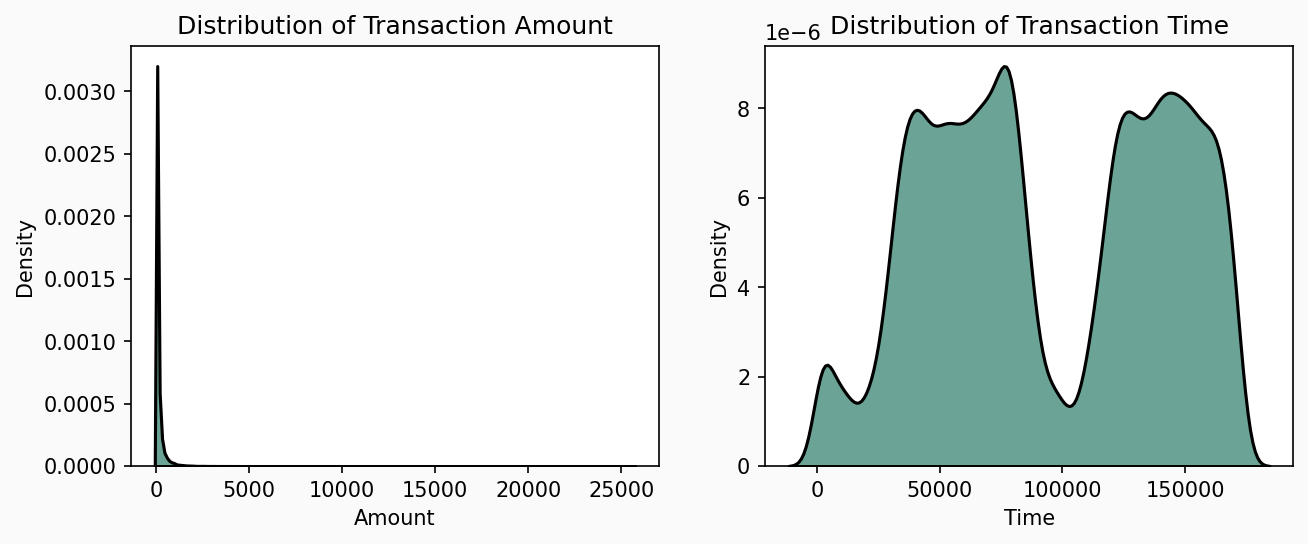

In [8]:
import matplotlib.gridspec as grid_spec
fig = plt.figure(figsize=(10, 8), dpi=150, facecolor='#fafafa') #plot background color, light grey
plt.title("Variable Distribution", loc='left')
gs = grid_spec.GridSpec(2, 2)
background_color = "#fafafa"

ax1 = plt.subplot(gs[0:1])
sns.kdeplot(df['Amount'], color='#5B9A8B', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
ax1.set_title('Distribution of Transaction Amount')

ax2 = plt.subplot(gs[1:2])
sns.kdeplot(df['Time'], color='#5B9A8B', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
ax2.set_title('Distribution of Transaction Time')

plt.show()


## 2. Scaling and Distributing
In this step, we will first scale the columns for **Time** and **Amount**. 

As we can see from the distribution plots, the scales are very different for the two, and they shoul dbe scaled as the other columns.

We also need to create **sub-samples** in order to have equal amount of pos and neg (fraud and no fraud) to help our algorithm train better.

We are creating sub-sample for the following reasons:
* **Overfitting**: Our classigication model will assume that most cases are no frauds because it learns from 99% of negative data.
* **Wrong Correlations**: Althought we don't know what V features mean here, it will be useful to understand how these features influence the results and by having an imbalances data, we are not able to see the true correlations between class and features.

In [9]:
#scaling the Time and Amount columns that has not been scaled like the other columns

from sklearn.preprocessing import StandardScaler, RobustScaler

#Robust Scaler less prone to outliers

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1)) #Reshape your data using array.reshape(-1, 1) if your data has a single feature as it will expect a 2D array
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Amount', 'Time'], axis=1, inplace=True)

In [10]:
# df.head()

## 3. Splitting the data
It is important that we have to separate the data **BEFORE** implementing the sampling technique. 

This is because we want to test our models on the **ORIGINAL** testing set, NOT ON the testing set created by these techniques. 

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

#splitting to n=5 folds split between train and test
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print(f"Fold {i}:")
    print("Train: ", train_index)
    print("Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

Fold 0:
Train:  [ 30473  30496  31002 ... 284804 284805 284806]
Test: [    0     1     2 ... 57017 57018 57019]
Fold 1:
Train:  [     0      1      2 ... 284804 284805 284806]
Test: [ 30473  30496  31002 ... 113964 113965 113966]
Fold 2:
Train:  [     0      1      2 ... 284804 284805 284806]
Test: [ 81609  82400  83053 ... 170946 170947 170948]
Fold 3:
Train:  [     0      1      2 ... 284804 284805 284806]
Test: [150654 150660 150661 ... 227866 227867 227868]
Fold 4:
Train:  [     0      1      2 ... 227866 227867 227868]
Test: [212516 212644 213092 ... 284804 284805 284806]


In [12]:
#Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

In [13]:
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

#counting how many fraud and no frauds in y train and y test to make sure the distribution is similar.

Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


## 4.0 Method 1: Under sampling
This step consist of removing rows from the larger % of label (no fraud) to match the % of the smaller represented label (fraud). 

The issue wit Under sampling is that we risk the classification model from performing as accurate as we would like to since there is a great amount of **information loss**.

In [14]:
#random shuffling dataframe by rows
df = df.sample(frac=1)

#choose 492 rows 
fraud_df = df.loc[df['Class'] == 1]
nofraud_df = df.loc[df['Class'] == 0][:492]

combined_data = pd.concat([fraud_df, nofraud_df])
# combined_data.head()

#after concat, shuffle AGAIN
underSample_df = combined_data.sample(frac=1, random_state=42)
underSample_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
15981,-0.705999,1.287481,0.724088,0.647910,0.138439,0.109952,0.191690,0.657146,-0.828868,-0.091963,...,0.581344,-0.133430,-0.315350,-0.258047,-0.279698,0.301385,0.142592,0,-0.274855,-0.672881
141258,-0.937843,3.462889,-6.445104,4.932199,-2.233983,-2.291561,-5.695594,1.338825,-4.322377,-8.099119,...,-0.521657,-0.319917,-0.405859,0.906802,1.165784,1.374495,0.729889,1,-0.307413,-0.005733
112150,1.256510,0.619944,-0.318895,0.909406,-0.091248,-1.595331,0.413286,-0.346925,-0.203829,-0.601884,...,-0.269518,-0.040549,0.628888,0.532764,0.347976,-0.032586,0.040274,0,-0.296793,-0.142847
149357,-1.855061,1.554964,-1.405809,0.669327,-0.280230,1.178652,-3.459979,-2.815155,1.242229,-4.156354,...,0.946629,-0.297403,-0.368344,0.198731,-0.078591,0.366709,0.073767,1,0.234193,0.074989
12369,-18.018561,10.558600,-24.667741,11.786180,-10.564657,-2.645681,-18.023468,2.693655,-6.219464,-12.744761,...,0.908839,1.352904,-1.059222,0.185751,0.687037,2.078081,-1.429517,1,-0.293440,-0.740493


0    0.5
1    0.5
Name: Class, dtype: float64


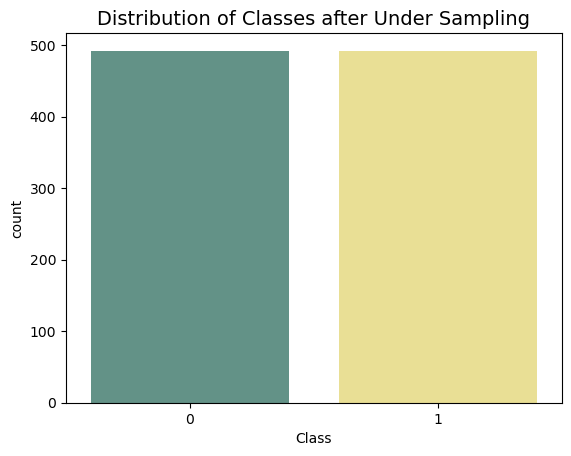

In [15]:
print(underSample_df['Class'].value_counts()/len(underSample_df))

#Visualise
sns.countplot(x='Class', data=underSample_df, palette=colors)
plt.title('Distribution of Classes after Under Sampling', fontsize=14)
plt.show()

## 4.1 Correlation Matrix
Now that we have equally distributed the data between positive and negative labels, we can use correlation matrix to find features that influence heavily on whether the transaction is a fraud or not. 

It is important we use the right dataframe -> subsample in order to see which features have high positive correlation and negative correlation.

**Boxplots** - can be used to get better understanding of the distribution of these features.

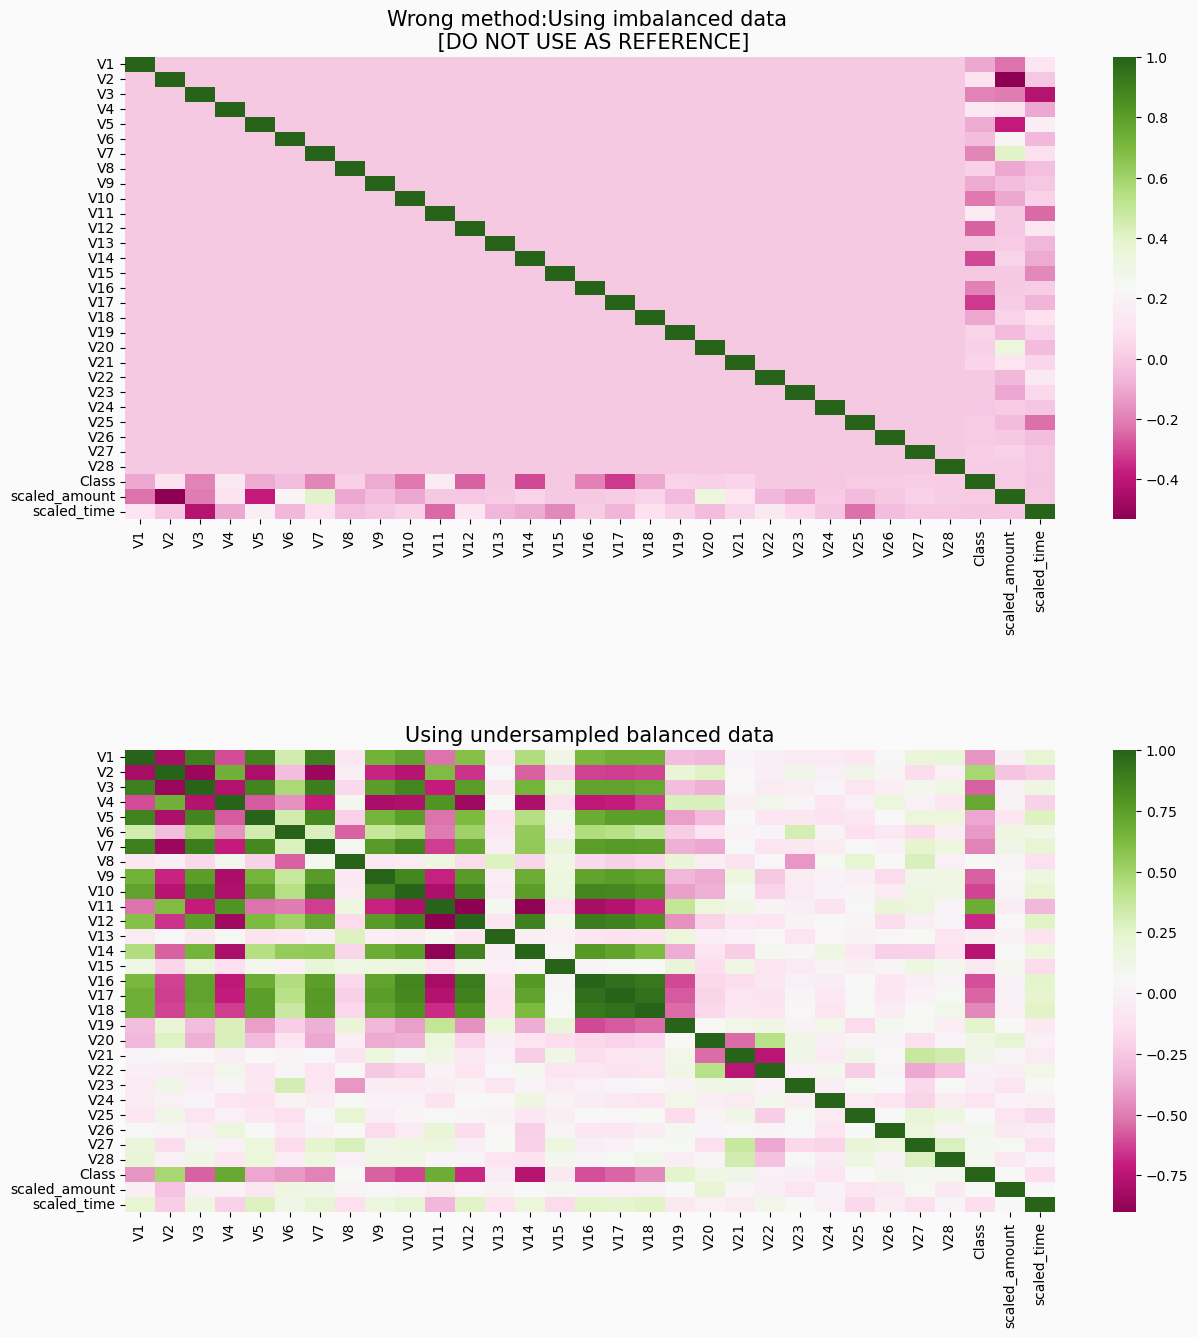

In [16]:
fig = plt.figure(figsize=(15, 15), facecolor='#fafafa') #plot background color, light grey
gs = grid_spec.GridSpec(2, 1)
gs.update(wspace=0.11, hspace=0.5)
background_color = "#fafafa"

ax0 = plt.subplot(gs[0,:])
corr = df.corr()
sns.heatmap(corr, cmap='PiYG', annot_kws={'size':20})
ax0.set_title('Wrong method:Using imbalanced data \n [DO NOT USE AS REFERENCE]',fontsize=15)

ax1 = plt.subplot(gs[1,:])
subsample_corr = underSample_df.corr()
sns.heatmap(subsample_corr,  cmap='PiYG', annot_kws={'size':20})
ax1.set_title('Using undersampled balanced data', fontsize=15)



plt.show()


### Observations from heatmap correlation 
* Negative Correlations: V17, V14, V12 and V10 are negatively correlated to CLASS. Notice how the lower these values are, the more likely the end result will be a fraud transaction.
* Positive Correlations: V2, V4, V11, and V19 are positively correlated to CLASS. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

Next, we can also use box plots to gain more insights on the distribution of these features in fraud and no fraud transactions. 

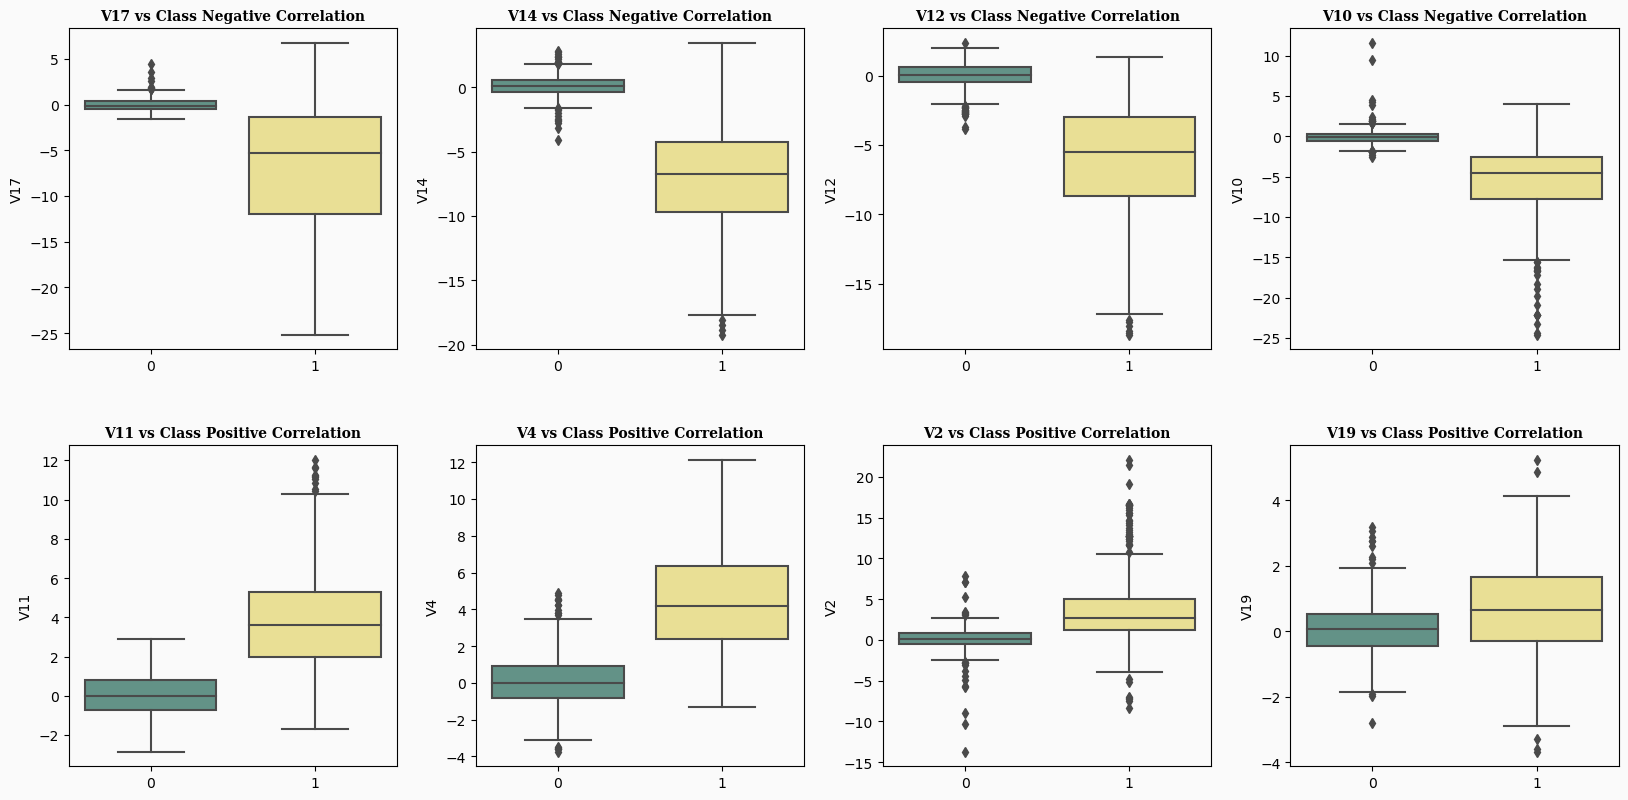

In [17]:
fig = plt.figure(figsize=(20, 15), facecolor='#fafafa') #plot background color, light grey
gs = grid_spec.GridSpec(3, 4)
gs.update(wspace=0.24, hspace=0.30)
background_color = "#fafafa"

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[1, 3])

#First row with negative correlated features, which are V10, V12, V14, V17
sns.boxplot(x="Class", y="V17", data=underSample_df, palette=colors, ax=ax0)
ax0.set_title('V17 vs Class Negative Correlation', fontsize=10, fontweight='bold', fontfamily='serif')

sns.boxplot(x="Class", y="V14", data=underSample_df, palette=colors, ax=ax1)
ax1.set_title('V14 vs Class Negative Correlation', fontsize=10, fontweight='bold', fontfamily='serif')


sns.boxplot(x="Class", y="V12", data=underSample_df, palette=colors, ax=ax2)
ax2.set_title('V12 vs Class Negative Correlation', fontsize=10, fontweight='bold', fontfamily='serif')


sns.boxplot(x="Class", y="V10", data=underSample_df, palette=colors, ax=ax3)
ax3.set_title('V10 vs Class Negative Correlation', fontsize=10, fontweight='bold', fontfamily='serif')


#Positive correlation features, V11, V4, V2, V19
sns.boxplot(x="Class", y="V11", data=underSample_df, palette=colors, ax=ax4)
ax4.set_title('V11 vs Class Positive Correlation', fontsize=10, fontweight='bold', fontfamily='serif')

sns.boxplot(x="Class", y="V4", data=underSample_df, palette=colors, ax=ax5)
ax5.set_title('V4 vs Class Positive Correlation', fontsize=10, fontweight='bold', fontfamily='serif')


sns.boxplot(x="Class", y="V2", data=underSample_df, palette=colors, ax=ax6)
ax6.set_title('V2 vs Class Positive Correlation', fontsize=10, fontweight='bold', fontfamily='serif')


sns.boxplot(x="Class", y="V19", data=underSample_df, palette=colors, ax=ax7)
ax7.set_title('V19 vs Class Positive Correlation', fontsize=10, fontweight='bold', fontfamily='serif')

#removing the x axis title 'Class' for neater look
for i in range(0,8):
    locals()["ax"+str(i)].set_xlabel('')
    locals()["ax"+str(i)].set_facecolor(background_color)

plt.show()


As we can see above, for each feature, there are outliers that are situated outside the box plots. We will aim to remove "extreme outliers" from features that have high correlation with our classes. This will have a positive impact and improve the accuracy of our model. Outliers create noise and distorts the accuracy of mdels but remember we have to avoid large information loss, as this can also cause our model to underfit.

* On the box plot, there is the 25th and 75th percentile located at both the end of the squares, it is easy to detect the extreme outliers with this visualisation.

* **Interquartile range:** We can also calculate the interquartile range between 75th percentile and 25th percentile to create a threshold beyond the 25th and 75th percentile where the instance will be deleted as they are outliers. 

Also, between Class 0 (no fraud) and Class 1(fraud), we can see a clear distinction between the two classification groups except for V19 where there may be a cross over around 0 where it could be either fraud or not fraud. 

**IMPORTANT NOTES**
We want to remove the extreme outliers here and not just outliers, because we don't want to run the risk of information loss which will cause our model to have lower accuracy. We can play with this threshold and see how it affects the accuracy. We have to be careful setting the threshold for removing outliers.

We determine the threshold by multiplying a number to the interquartile range. The higher the threshold is, the less outliers it detects,the lower the threshold is, the more outliers it detects.

In addition to refering to the boxplots for outlier points to know the extent of outliers in each features, we must also consider the strength of correlation to our Class. The stronger the correlation of feature to the Class, the higher the impact of outliers in our model.

Let's refer back to our correlation matrix to find the 3 highest correlation features to Class:
1. V14, V12, V10 are all strongly (dark shades of pink) negative correlated
2. V4, V11, V2 are strongly (dark shades of green) positive correlated

Considering the skewness and strength of correlation, we will asses and remove outliers from the following features:
**V14, V10, V2**

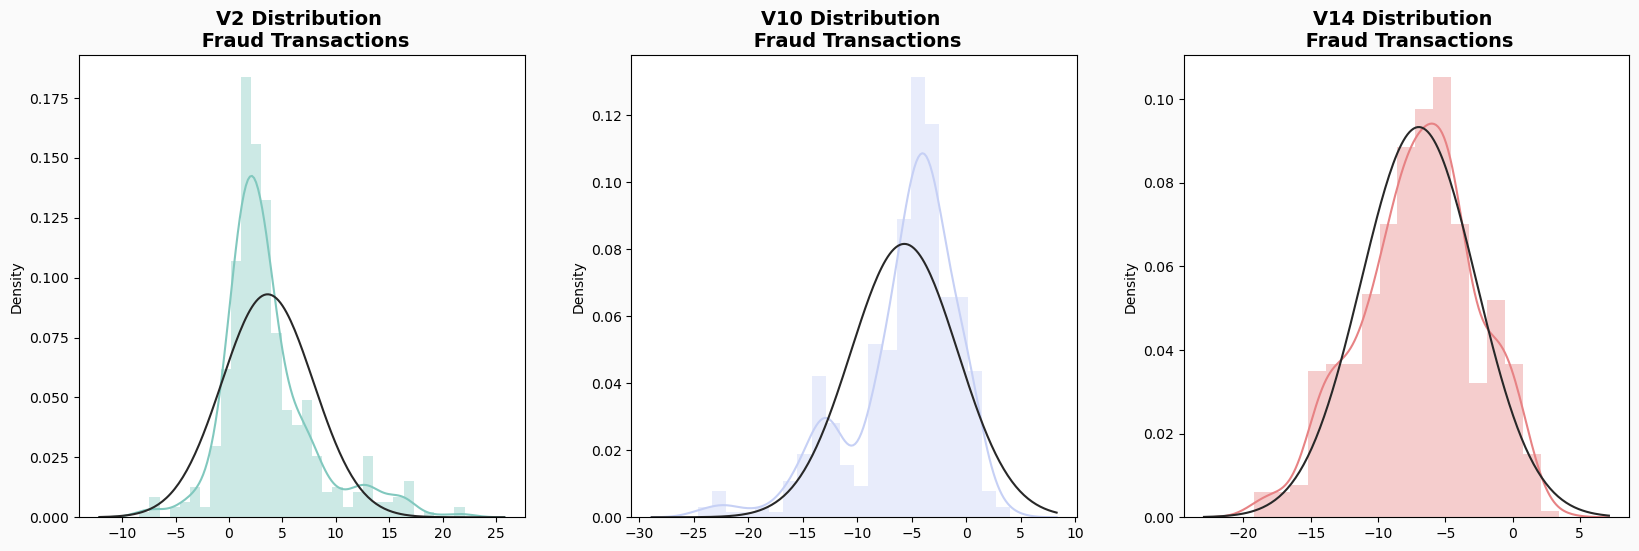

In [18]:
from scipy.stats import norm #black lines of what normal distribution would look like

# let's plot it out 
fig = plt.figure(figsize=(20, 6), facecolor='#fafafa') #plot background color, light grey
gs = grid_spec.GridSpec(1, 3)
gs.update(wspace=0.24, hspace=0.30)
background_color = "#fafafa"

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

#V2
v2_fraud_dist = underSample_df['V2'].loc[underSample_df['Class']==1].values #loc selected data by label
sns.distplot(v2_fraud_dist, ax=ax0, fit=norm, color = '#81c8be')
ax0.set_title('V2 Distribution \n Fraud Transactions', fontsize=14, fontweight='bold')
                
#V10
v10_fraud_dist = underSample_df['V10'].loc[underSample_df['Class']==1].values #loc selected data by label
sns.distplot(v10_fraud_dist, ax=ax1, fit=norm, color = '#c6d0f5')
ax1.set_title('V10 Distribution \n Fraud Transactions', fontsize=14, fontweight='bold')

#V14
v14_fraud_dist = underSample_df['V14'].loc[underSample_df['Class']==1].values #loc selected data by label
sns.distplot(v14_fraud_dist, ax=ax2, fit=norm, color = '#e78284')
ax2.set_title('V14 Distribution \n Fraud Transactions', fontsize=14, fontweight='bold')

plt.show()


## 4.2 Removing Extreme Outliers

In [19]:

## V14 Removing Outliers (Highest Negative Correlated with Labels)
print("Removing outliers in V14...")
v14_fraud = underSample_df['V14'].loc[underSample_df['Class'] == 1].values
#find qrt25 and 75
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print(f'Quartile 25: {q25} | Quartile 75: {q75}')
v14_iqr = q75 - q25
print(f'Interquartile: {v14_iqr}')

#set threshold/cut off
v14_cut_off = v14_iqr * 1.5

v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print(f'Cut Off: {v14_cut_off}')
print(f'V14 Lower: {v14_lower}')
print(f'V14 Upper: {v14_upper}')

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print(f'Feature V14 Outliers for Fraud Cases: {len(outliers)}')
print(f'V12 outliers:{outliers}')

underSample_df = underSample_df.drop(underSample_df[(underSample_df['V14'] > v14_upper) | (underSample_df['V14'] < v14_lower)].index)
print('----' * 40)

## V10 Removing Outliers (Highest Negative Correlated with Labels)
print("Removing outliers in V10...")
v10_fraud = underSample_df['V10'].loc[underSample_df['Class'] == 1].values
#find qrt25 and 75
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print(f'Quartile 25: {q25} | Quartile 75: {q75}')
v10_iqr = q75 - q25
print(f'Interquartile: {v10_iqr}')

#set threshold/cut off
v10_cut_off = v10_iqr * 1.5

v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print(f'Cut Off: {v10_cut_off}')
print(f'V10 Lower: {v10_lower}')
print(f'V10 Upper: {v10_upper}')

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print(f'Feature V10 Outliers for Fraud Cases: {len(outliers)}')
print(f'V10 outliers:{outliers}')

underSample_df = underSample_df.drop(underSample_df[(underSample_df['V10'] > v10_upper) | (underSample_df['V10'] < v10_lower)].index)
print('----' * 40)

## V2 Removing Outliers (Highest Negative Correlated with Labels)
print("Removing outliers in V2...")
v2_fraud = underSample_df['V2'].loc[underSample_df['Class'] == 1].values
#find qrt25 and 75
q25, q75 = np.percentile(v2_fraud, 25), np.percentile(v2_fraud, 75)
print(f'Quartile 25: {q25} | Quartile 75: {q75}')
v2_iqr = q75 - q25
print(f'Interquartile: {v2_iqr}')

#set threshold/cut off
v2_cut_off = v2_iqr * 1.5

v2_lower, v2_upper = q25 - v10_cut_off, q75 + v10_cut_off
print(f'Cut Off: {v2_cut_off}')
print(f'V2 Lower: {v2_lower}')
print(f'V2 Upper: {v2_upper}')

outliers = [x for x in v2_fraud if x < v2_lower or x > v2_upper]
print(f'Feature V2 Outliers for Fraud Cases: {len(outliers)}')
print(f'V2 outliers:{outliers}')

underSample_df = underSample_df.drop(underSample_df[(underSample_df['V2'] > v2_upper) | (underSample_df['V2'] < v2_lower)].index)
print('----' * 40)

Removing outliers in V14...
Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
Interquartile: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V12 outliers:[-18.8220867423816, -18.4937733551053, -19.2143254902614, -18.0499976898594]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Removing outliers in V10...
Quartile 25: -7.537184847592775 | Quartile 75: -2.53746481466505
Interquartile: 4.999720032927725
Cut Off: 7.499580049391588
V10 Lower: -15.036764896984362
V10 Upper: 4.962115234726538
Feature V10 Outliers for Fraud Cases: 25
V10 outliers:[-15.2318333653018, -22.1870885620007, -16.6011969664137, -18.9132433348732, -16.2556117491401, -22.1870885620007, -22.1870885620007, -15.5637913387301, -24.5882624372475, -15.1241628144947, -16.6496281595399, -22.1870885620007

Text(0.5, 1.0, 'V2 vs Class Negative Correlation')

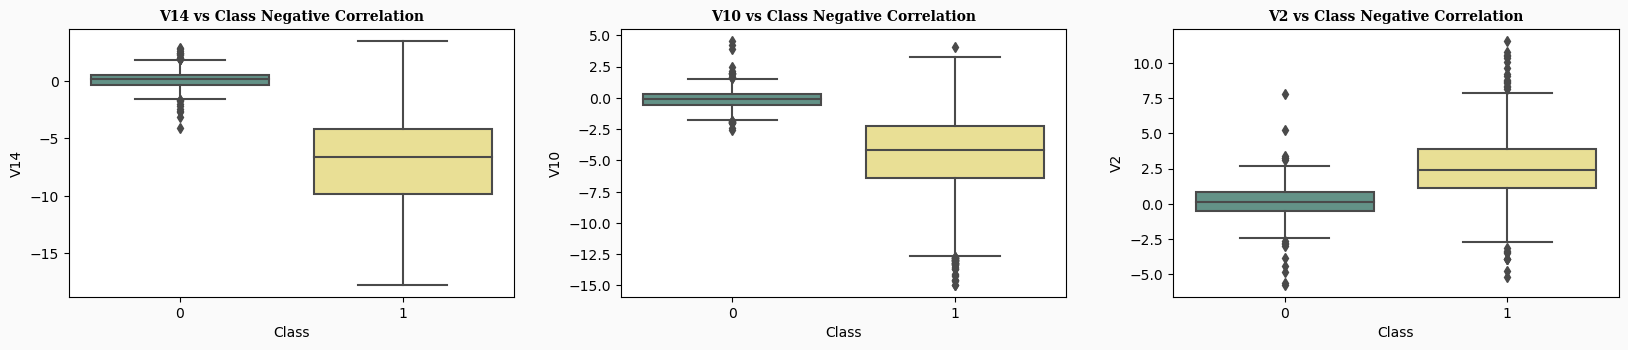

In [20]:
fig = plt.figure(figsize=(20, 8), facecolor='#fafafa') #plot background color, light grey
gs = grid_spec.GridSpec(2, 3)
gs.update(wspace=0.24, hspace=0.30)
background_color = "#fafafa"

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])


#First row with negative correlated features, which are V10, V12, V14, V17
sns.boxplot(x="Class", y="V14", data=underSample_df, palette=colors, ax=ax0)
ax0.set_title('V14 vs Class Negative Correlation', fontsize=10, fontweight='bold', fontfamily='serif')

sns.boxplot(x="Class", y="V10", data=underSample_df, palette=colors, ax=ax1)
ax1.set_title('V10 vs Class Negative Correlation', fontsize=10, fontweight='bold', fontfamily='serif')


sns.boxplot(x="Class", y="V2", data=underSample_df, palette=colors, ax=ax2)
ax2.set_title('V2 vs Class Negative Correlation', fontsize=10, fontweight='bold', fontfamily='serif')


By comparing the previous box plots for the features we have chosen, we can see that some outlier points have been removed. 

## 4.4 Training Classification Model with Undersampled Data
We will train 4 types of classifiers and decide which will be most effective indecting fraud transactions.

In [21]:
# Undersampling before cross validating (prone to overfit)
X = underSample_df.drop('Class', axis=1)
y = underSample_df['Class']

In [22]:
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [23]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [24]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 95.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score
Classifiers:  SVC Has a training score of 94.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 91.0 % accuracy score


In [25]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)

grid_log_reg.fit(X_train, y_train)

# logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

#KNN
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)

grid_knears.fit(X_train, y_train)

# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)

grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)

grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [26]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.71%
Knears Neighbors Cross Validation Score 94.16%
Support Vector Classifier Cross Validation Score 94.98%
DecisionTree Classifier Cross Validation Score 93.22%


Logistic regression has the highest score in cross-validation. Let's see if this is the same for our testing data.

In [27]:
from sklearn.metrics import confusion_matrix

logreg_pred  = log_reg.predict(X_test)
knn_pred  = knears_neighbors.predict(X_test)
svc_pred   = svc.predict(X_test)
tree_pred = tree_clf.predict(X_test)

logreg_cm  = confusion_matrix(y_test,logreg_pred )
knn_cm = confusion_matrix(y_test,knn_pred)
svm_cm  = confusion_matrix(y_test,svc_pred)
tree_cm = confusion_matrix(y_test, tree_pred)

In [28]:
print(classification_report(y_test,logreg_pred))
print("LOGISTIC REGRESSION SCORE:")
print('Accuracy Score: ',accuracy_score(y_test,logreg_pred))
print('F1 Score: ',f1_score(y_test,logreg_pred))
print("-----"*20)

print(classification_report(y_test,knn_pred))
print("K NEAREST NEIGHBOUR SCORE:")
print('Accuracy Score: ',accuracy_score(y_test,knn_pred))
print('F1 Score: ',f1_score(y_test,knn_pred))
print("-----"*20)

print(classification_report(y_test,svc_pred))
print("SVM SCORE:")
print('Accuracy Score: ',accuracy_score(y_test,svc_pred))
print('F1 Score: ',f1_score(y_test,svc_pred))
print("-----"*20)

print(classification_report(y_test,tree_pred))
print("DECISION TREE SCORE:")
print('Accuracy Score: ',accuracy_score(y_test,tree_pred))
print('F1 Score: ',f1_score(y_test,tree_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        92
           1       1.00      0.83      0.91        93

    accuracy                           0.91       185
   macro avg       0.93      0.91      0.91       185
weighted avg       0.93      0.91      0.91       185

LOGISTIC REGRESSION SCORE:
Accuracy Score:  0.9135135135135135
F1 Score:  0.9058823529411765
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        92
           1       0.98      0.86      0.91        93

    accuracy                           0.92       185
   macro avg       0.92      0.92      0.92       185
weighted avg       0.92      0.92      0.92       185

K NEAREST NEIGHBOUR SCORE:
Accuracy Score:  0.918918918918919
F1 Score:  0.9142857142857143
------------------------------------------------------------

Looks like SVM model has the highest accuracy score (95.1%) and f1 score (94.8%). Now let's dive into the confusion matrix visualisations to understand the meaning behind these scores.

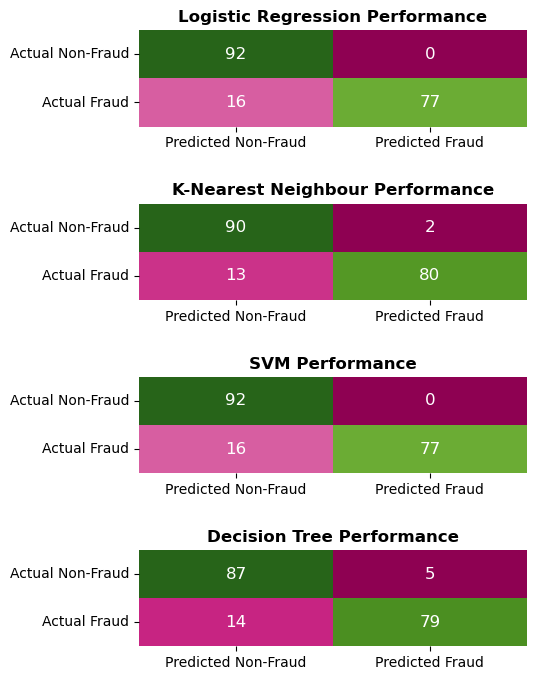

In [29]:
fig = plt.figure(figsize=(5,8)) # create figure
gs = fig.add_gridspec(4, 1)
gs.update(wspace=0.1, hspace=0.8)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])
ax0.set_facecolor(background_color) # axes background color

# Overall
sns.heatmap(logreg_cm, cmap="PiYG",annot=True,cbar=False,ax=ax0,annot_kws={"fontsize":12},
            yticklabels=['Actual Non-Fraud','Actual Fraud'],xticklabels=['Predicted Non-Fraud','Predicted Fraud'])
ax0.set_title("Logistic Regression Performance", fontweight="bold")

sns.heatmap(knn_cm, cmap="PiYG",annot=True,cbar=False,ax=ax1,annot_kws={"fontsize":12},
           yticklabels=['Actual Non-Fraud','Actual Fraud'],xticklabels=['Predicted Non-Fraud','Predicted Fraud'])
ax1.set_title("K-Nearest Neighbour Performance", fontweight="bold")

sns.heatmap(svm_cm, cmap="PiYG",annot=True,cbar=False,ax=ax2,annot_kws={"fontsize":12},
           yticklabels=['Actual Non-Fraud','Actual Fraud'],xticklabels=['Predicted Non-Fraud','Predicted Fraud'])
ax2.set_title("SVM Performance", fontweight="bold")

sns.heatmap(tree_cm, cmap="PiYG",annot=True,cbar=False,ax=ax3,annot_kws={"fontsize":12},
           yticklabels=['Actual Non-Fraud','Actual Fraud'],xticklabels=['Predicted Non-Fraud','Predicted Fraud'])
ax3.set_title("Decision Tree Performance", fontweight="bold")

plt.show()

We can observe that the Support Vector Machine model's accuracy score and f1 score is the highest among the 4 models. 

However, we can see that the Logistic Regression model has the highest True Positives. Although the model has the highest amount of False Positives, the more important thing for this problem is it is better to have more False Positives (non fraud predicted as fraud) than False Negatives (fraud predicted as non fraud). 

For these reasons, I will choose is the Logistic Regression model. 

### Understanding the confusion matics through math
<img src="http://miro.medium.com/v2/resize:fit:830/format:webp/1*uR09zTlPgIj5PvMYJZScVg.png"/>


In real world cases, especially in health care datasets, sometimes it is better to have false negatives than false positives as it is important to detected more positives. This allows the detection of patients that actually have a specific disease that might be life threatening, so that medication/treatment can be given. 

More examples include:
* Medical research - you’d rather have a **false positive** for a patient with cancer rather than a false negative. You classify it as having cancer when the patient doesn’t compared to saying he doesn’t when he/she actually does.
* Credit approval - in my opinion it is better to have **false negatives** compared to false positives. If a customer repays his debt or not. False positives lose you money.
* Customer profitability - there are a few industries where customers can lose or make money for the company. So in a case where we want to identify a customer that will be profitable we’d rather have **false negatives** over false positives.

## 5.0 Conclusion

We carried out data pre-processing by checking the overall data and understanding the relationships between features on the target label of the data. 

During the process, we found that the data is imbalanced as there were more non-fraud data as compared to fraud. Therefore, we undersampled the samples with non-fraud targets by shuffling the rows and picking the same number of samples (457) as fraud data. THere were also afew features that are positive and negatively correlated to the target outcome and we removed extreme outliers depending on how much impact the feature has on the target and on the skewness of the data. 

Using the cleaned and undersampled data, we split the data into training and testing data sets. The training set is used to train 3 models: Logistric Regression, KNN and SVM. GridSearch is used for all 3 models to perform hyper-parameter optimisation by scanning the data to configure optimal parameters. We then repeated these steps with cross validation of cv=5. 

Finally, we ran the testing dataset through the models for prediction. The results showed that **Linear Regression** has the best performance in detecting frauds.